# F21 AA. CW 1
# TASK 4 Model Training ,tuning and evaluation

# K Nearest Neighbor AND Support Vector Machines

Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import LinearSVC

import seaborn as sns
import mglearn
import matplotlib.pyplot as plt
# Custom PreprocessAndNorm.pynb module to perform preprocessing and Normalization for function reuse
%run ProcessingAndNorm.ipynb

/Users/amit/anaconda3/envs/F21TA/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/Users/amit/anaconda3/envs/F21TA/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
[nltk_data] Downloading package stopwords to /Users/amit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/amit/n

Inputs - train Data 

In [2]:
# Preprocessed data from step 2 which used Stemming
df_reviews_p_s = pd.read_csv('df_reviews_p_s.csv')
df_reviews_p_s.head()

,Unnamed: 0,Score,Summary_text,length,word_count,length_change,wordcount_change
0,0,5,good receiv product earli seller tastey great ...,103,16,104,24
1,1,5,organ kosher tasti assort premium tea teasan n...,1199,193,799,126
2,2,5,excel glutenfre spaghetti great tast great str...,619,101,527,103
3,3,5,lindt lindt buy multipack misl pictur whole ha...,117,19,84,15
4,4,5,yum bar good love warm definit think great sna...,88,14,76,15


In [3]:
# Preprocessed data from step 2 which used Lemmatization
df_reviews_p_l = pd.read_csv('df_reviews_p_l.csv')
df_reviews_p_l.head()

,Unnamed: 0,Score,Summary_text,length,word_count,length_change,wordcount_change
0,0,5,good received product early seller tastey grea...,109,16,98,24
1,1,5,organic kosher tasty assortment premium tea te...,1334,193,664,126
2,2,5,excellent glutenfree spaghetti great taste gre...,690,101,456,103
3,3,5,lindt lindt buying multipack misled picture wh...,138,19,63,15
4,4,5,yum bar good loved warmed definitely think gre...,98,14,66,15


Inputs - Test Data

In [4]:
df_test=pd.read_csv('test.csv')
df_label=pd.read_csv('labels.csv')


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142114 entries, 0 to 142113
Data columns (total 9 columns):
Id                        142114 non-null int64
ProductId                 142114 non-null object
UserId                    142114 non-null object
ProfileName               142112 non-null object
HelpfulnessNumerator      142114 non-null int64
HelpfulnessDenominator    142114 non-null int64
Time                      142114 non-null int64
Summary                   142107 non-null object
Text                      142114 non-null object
dtypes: int64(4), object(5)
memory usage: 9.8+ MB


In [6]:
df_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142114 entries, 0 to 142113
Data columns (total 2 columns):
Id       142114 non-null int64
Score    142114 non-null int64
dtypes: int64(2)
memory usage: 2.2 MB


Reuse preprocessing done in task 2

In [7]:
df_test_data = pd.merge(df_label, df_test, on='Id')
df_test_data.Summary.fillna('',inplace=True)
df_test_data.Text.fillna('', inplace=True)
df_test_data['Summary_text']=df_test_data['Summary']+" "+df_test_data['Text']
df_test_data = df_test_data[['Score','Summary_text']]
df_test_data['Score']=df_test_data.Score.astype('category')
df_test_data=Perform_Preprocessing(df_test_data)
df_test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142114 entries, 0 to 142113
Data columns (total 2 columns):
Score           142114 non-null category
Summary_text    142114 non-null object
dtypes: category(1), object(1)
memory usage: 2.3+ MB


In [52]:
X_test=df_test_data['Summary_text']
X_test

0         love flavor fog chaser best flavor body far pr...
1         tasty tea found pf changs tastes great 16 bags...
2         yum quite chocolate bar substitute delicious a...
3         gluten free biscotti tasty pamelas almond bisc...
4         happy puppies hrefhttpwwwamazoncomgpproductb00...
                                ...                        
142109    great treats buying store hard time keeping st...
142110    nongmo magnesium boost glad companies making p...
142111    real thing similar love real scottish haggis b...
142112    wow awesome syrup eat lot syrup house three ye...
142113    dog buy give dog needs lose weight gets hungry...
Name: Summary_text, Length: 142114, dtype: object

In [54]:

Y_test=df_test_data['Score']
Y_test

0         5
1         5
2         5
3         3
4         4
         ..
142109    5
142110    5
142111    4
142112    5
142113    5
Name: Score, Length: 142114, dtype: category
Categories (5, int64): [1, 2, 3, 4, 5]

# Running KNN and SVM to get baseline

We first test both KNN and SVM on unigram version to check training time and performance before choosing one algorithm

Define train data

In [10]:
X_train=df_reviews_p_s['Summary_text']
Y_train=df_reviews_p_s['Score']

## KNN

Create Pipe for KNN 

In [11]:
pipe_KNN = Pipeline([
    ('bow', CountVectorizer(analyzer='word',ngram_range=(1,1),min_df=25)),  # strings to token integer counts
    ('classifier', KNeighborsClassifier(n_neighbors =5)),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

Fit train data on Pipe

In [13]:
pipe_KNN.fit(X_train,Y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=25,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classifier',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=5, p=2,
                                      weights='uniform'))],
         verbose=False)

Predict Test data

In [14]:
predictions_KNN = pipe_KNN.predict(X_test)

Print Result

In [15]:
print(classification_report(predictions_KNN,Y_test))

              precision    recall  f1-score   support

           1       0.28      0.53      0.37      7033
           2       0.21      0.50      0.30      3070
           3       0.22      0.49      0.31      4846
           4       0.23      0.51      0.32      9171
           5       0.93      0.72      0.81    117994

    accuracy                           0.68    142114
   macro avg       0.38      0.55      0.42    142114
weighted avg       0.82      0.68      0.73    142114



Initial Discussion:Although the results were better than that of naive bayes baseline, KNN took too long for even the simplest
case and would not be ideal for use with gridseach and pipeline. This algorithm being computationally very expensive, we decided to move onto SVM

## SVM

Create Pipe line for SVC

In [74]:

pipe_SVC = Pipeline([
    ('Tfidf', TfidfVectorizer(analyzer='word',ngram_range=(1,1),min_df=25)),  # strings to token integer counts
    ('classifier', LinearSVC()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])


Fit train data 

In [75]:
pipe_SVC.fit(X_train,Y_train)

Pipeline(memory=None,
         steps=[('Tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=25, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
       

Make predictions using Test data 

In [76]:
predictions_SVC = pipe_SVC.predict(X_test)

Print Results

In [77]:
print(classification_report(predictions_SVC,Y_test))

              precision    recall  f1-score   support

           1       0.54      0.60      0.57     11623
           2       0.12      0.40      0.19      2255
           3       0.25      0.44      0.32      6161
           4       0.16      0.42      0.24      7836
           5       0.94      0.75      0.84    114239

    accuracy                           0.70    142114
   macro avg       0.40      0.52      0.43    142114
weighted avg       0.83      0.70      0.75    142114



# Model Building,tuning and evaluation using SVM and Tf-IDF vectorization

Since TFIDF works better with SVM, we decided to test both preprocessed with stemming and lemma with TFIDF and not count Vectorization

### a)Preprocessed data with Stemming      

Set train data

In [11]:
X_train=df_reviews_p_s['Summary_text']
Y_train=df_reviews_p_s['Score']

Create Pipeline

In [29]:
pipeline1 = Pipeline([
    ('Tfidf', TfidfVectorizer(analyzer='word',min_df=25)),  # strings to token integer counts into TFIDF
    ('classifier', LinearSVC()),  # train on TF-IDF vectors w/ Support Vector Machines
])

Create parameter grid


In [30]:
param_grid1 = {'classifier__C': [0.1,0.3,0.5,1],
               "Tfidf__ngram_range": [(1, 1), (1, 2)]}

grid1 = GridSearchCV(pipeline1, param_grid1, cv=3)


Fit training data

In [31]:
grid1.fit(X_train, Y_train)
print("Best cross-validation score: {:.2f}".format(grid1.best_score_))

Best cross-validation score: 0.80


Print results

In [32]:
scores1 = grid1.cv_results_['mean_test_score'].reshape(-1, 2).T
scores1

array([[0.74467327, 0.75014073, 0.77923488, 0.8002627 ],
       [0.74917437, 0.75076699, 0.7965497 , 0.80109303]])

Display Heatmap of results


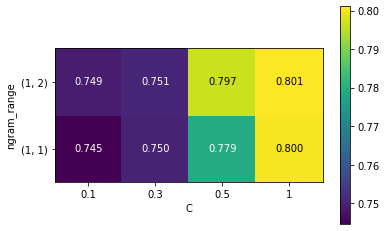

In [33]:
# visualize heat map

heatmap1 = mglearn.tools.heatmap(
    scores1, xlabel="C", ylabel="ngram_range", cmap="viridis", fmt="%.3f",
    xticklabels=param_grid1['classifier__C'],
    yticklabels=param_grid1['Tfidf__ngram_range'])
plt.colorbar(heatmap1)

Finetuned Pipe


In [55]:
pipe1 = Pipeline([
    ('Tfidf', TfidfVectorizer(analyzer='word',ngram_range=(1,2),min_df=25)),  # strings to token integer counts
    ('classifier', LinearSVC(C=1)),  # train on TF-IDF vectors w/ SVM
])



Fit training data


In [56]:
pipe1.fit(X_train,Y_train)

Pipeline(memory=None,
         steps=[('Tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=25, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 LinearSVC(C=1, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
         

Make predictions on test data


In [57]:
predictions1 = pipe1.predict(X_test)

Print Results

In [58]:
print(classification_report(predictions1,Y_test))

              precision    recall  f1-score   support

           1       0.60      0.65      0.63     12082
           2       0.30      0.44      0.36      5017
           3       0.38      0.50      0.43      8212
           4       0.33      0.47      0.39     14568
           5       0.91      0.81      0.86    102235

    accuracy                           0.73    142114
   macro avg       0.51      0.57      0.53    142114
weighted avg       0.77      0.73      0.75    142114



In [59]:
confusion_matrix(Y_test, predictions1)

array([[ 7870,   857,   633,   674,  3041],
       [ 1387,  2211,  1049,   722,  2047],
       [  804,   744,  4095,  1623,  3381],
       [  568,   515,  1272,  6804, 11187],
       [ 1453,   690,  1163,  4745, 82579]])

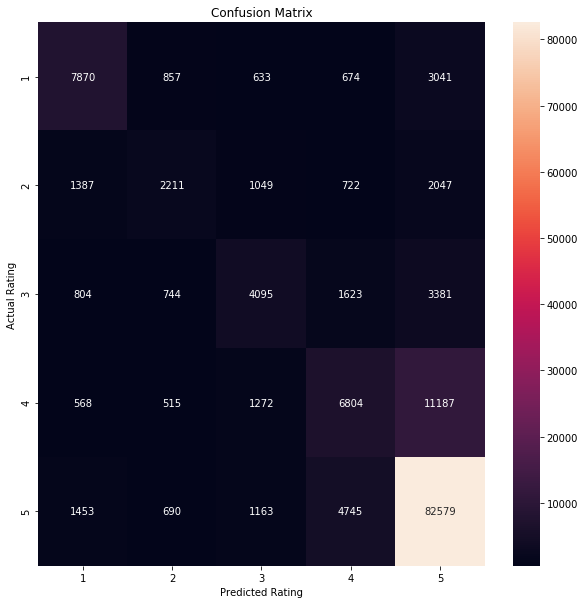

In [60]:
# Confusion matrix as a heatmap
conf_mat = confusion_matrix(Y_test, predictions1)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=df_reviews_p_s.Score.astype('category').cat.categories, 
            yticklabels=df_reviews_p_s.Score.astype('category').cat.categories)
plt.title('Confusion Matrix')
plt.ylabel('Actual Rating')
plt.xlabel('Predicted Rating')
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

### b)Preprocessed data with lemmatization      

Set train data 

In [15]:
X_train2=df_reviews_p_l['Summary_text']
Y_train2=df_reviews_p_l['Score']

Create Pipeline

In [22]:
pipeline2 = Pipeline([
    ('Tfidf', TfidfVectorizer(analyzer='word',min_df=25)),  # strings to token integer counts
    ('classifier', LinearSVC()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

Create parameter grid

In [25]:
param_grid2 = {'classifier__C': [0.1,0.5,1],
               "Tfidf__ngram_range": [(1, 1), (1, 2)]}

grid2 = GridSearchCV(pipeline2, param_grid2, cv=3)




Fit Training data

In [26]:
grid2.fit(X_train2, Y_train2)
print("Best cross-validation score: {:.2f}".format(grid2.best_score_))

Best cross-validation score: 0.80


Display results

In [27]:
scores2 = grid2.cv_results_['mean_test_score'].reshape(-1, 2).T
scores2

array([[0.74891401, 0.75625323, 0.80087254],
       [0.75569499, 0.78012854, 0.8014214 ]])

Display heatmap of results

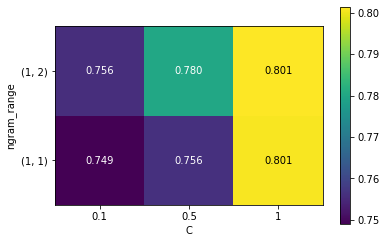

In [28]:
# visualize heat map

heatmap2 = mglearn.tools.heatmap(
    scores2, xlabel="C", ylabel="ngram_range", cmap="viridis", fmt="%.3f",
    xticklabels=param_grid2['classifier__C'],
    yticklabels=param_grid2['Tfidf__ngram_range'])
plt.colorbar(heatmap2)

Finetuned pipeline

In [16]:
pipe2 = Pipeline([
    ('Tfidf', TfidfVectorizer(analyzer='word',ngram_range=(1,2),min_df=25)),  # strings to token integer counts
    ('classifier', LinearSVC(C=1)),  # train on TF-IDF vectors w/ Support Vector Machines
])



Fit train data

In [17]:
pipe2.fit(X_train2,Y_train2)

Pipeline(memory=None,
         steps=[('Tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=25, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 LinearSVC(C=1, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
         

Predict for test data

In [18]:
predictions2 = pipe2.predict(X_test)

Display Results

In [19]:
print(classification_report(predictions2,Y_test))

              precision    recall  f1-score   support

           1       0.79      0.76      0.77     13558
           2       0.46      0.63      0.53      5392
           3       0.53      0.63      0.57      8874
           4       0.46      0.62      0.53     15103
           5       0.95      0.87      0.90     99187

    accuracy                           0.81    142114
   macro avg       0.64      0.70      0.66    142114
weighted avg       0.84      0.81      0.82    142114



In [20]:
confusion_matrix(Y_test, predictions2)

array([[10299,   749,   533,   354,  1140],
       [ 1560,  3376,   977,   473,  1030],
       [  761,   728,  5595,  1553,  2010],
       [  341,   284,  1117,  9403,  9201],
       [  597,   255,   652,  3320, 85806]])

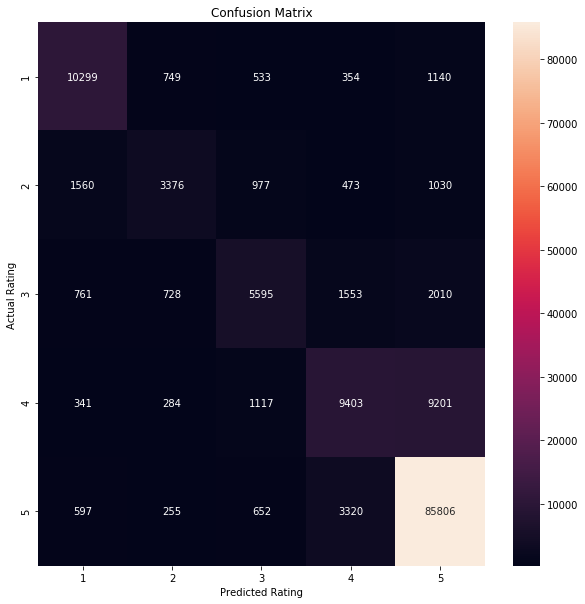

In [21]:
# Confusion matrix as a heatmap
conf_mat = confusion_matrix(Y_test, predictions2)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=df_reviews_p_s.Score.astype('category').cat.categories, 
            yticklabels=df_reviews_p_s.Score.astype('category').cat.categories)
plt.title('Confusion Matrix')
plt.ylabel('Actual Rating')
plt.xlabel('Predicted Rating')
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()